C:\Users\User\AppData\Local\Temp\ipykernel_7272\3219083487.py:47: RuntimeWarning: divide by zero encountered in divide
  eta = np.where(D > 0, 1.0 / D, 0.0)  # evita divisão por zero


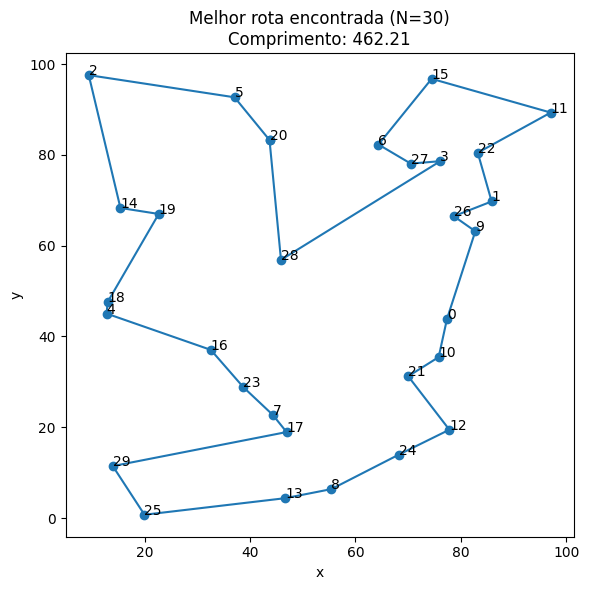

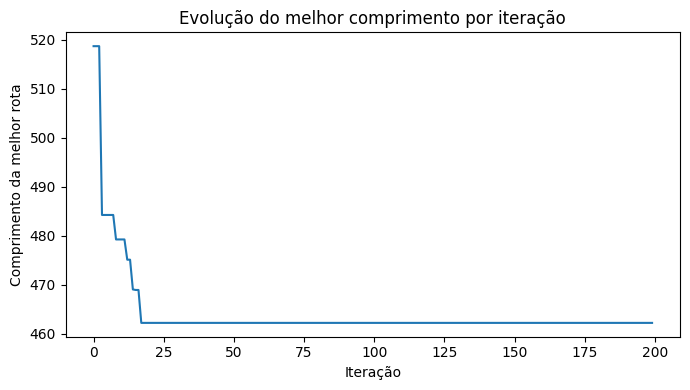

Best length: 462.209


In [3]:
import numpy as np
import matplotlib.pyplot as plt

def euclidean_distance_matrix(coords):
    """Calcula a matriz de distâncias euclidianas entre cidades."""
    n = len(coords)
    D = np.zeros((n, n), dtype=float)
    for i in range(n):
        for j in range(n):
            if i != j:
                D[i, j] = np.linalg.norm(coords[i] - coords[j])
    return D

def construct_solution(tau, eta, alpha, beta, rng):
    """Constrói uma solução (rota) usando as probabilidades de transição."""
    n = tau.shape[0]
    start = rng.integers(0, n)
    tour = [start]
    unvisited = set(range(n)) - {start}
    for _ in range(n - 1):
        i = tour[-1]
        nodes = list(unvisited)
        probs = np.array([(tau[i, j] ** alpha) * (eta[i, j] ** beta) for j in nodes], dtype=float)
        probs_sum = probs.sum()
        if probs_sum == 0.0:
            probs = np.ones_like(probs) / len(probs)
        else:
            probs = probs / probs_sum
        j = rng.choice(nodes, p=probs)
        tour.append(j)
        unvisited.remove(j)
    return tour

def tour_length(tour, D):
    """Calcula o comprimento total da rota."""
    length = sum(D[a, b] for a, b in zip(tour, tour[1:]))
    length += D[tour[-1], tour[0]]
    return length

def aco_tsp(coords, iters=200, n_ants=None, alpha=1.0, beta=5.0, rho=0.5, q=100.0, seed=42):
    """Executa o algoritmo ACO para o TSP."""
    rng = np.random.default_rng(seed)
    n = len(coords)
    if n_ants is None:
        n_ants = n
    D = euclidean_distance_matrix(coords)
    eta = np.where(D > 0, 1.0 / D, 0.0)  # evita divisão por zero
    tau = np.ones((n, n), dtype=float)
    np.fill_diagonal(tau, 0.0)

    best_tour = None
    best_len = np.inf
    history = []

    for t in range(iters):
        ants_tours = []
        ants_lengths = []
        for _ in range(n_ants):
            tour = construct_solution(tau, eta, alpha, beta, rng)
            L = tour_length(tour, D)
            ants_tours.append(tour)
            ants_lengths.append(L)
            if L < best_len:
                best_len = L
                best_tour = tour.copy()
        tau *= (1 - rho)
        best_idx = int(np.argmin(ants_lengths))
        tour_b = ants_tours[best_idx]
        L_b = ants_lengths[best_idx]
        for a, b in zip(tour_b, tour_b[1:] + tour_b[:1]):
            tau[a, b] += q / L_b
            tau[b, a] += q / L_b
        history.append(best_len)
    return best_tour, best_len, history, D

def plot_route(coords, tour, best_len):
    """Plota a melhor rota encontrada."""
    route_xy = coords[tour + [tour[0]]]
    plt.figure(figsize=(6, 6))
    plt.plot(route_xy[:,0], route_xy[:,1], marker='o')
    for idx, (x, y) in enumerate(coords):
        plt.text(x, y, str(idx))
    plt.title(f"Melhor rota encontrada (N={len(coords)})\nComprimento: {best_len:.2f}")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.tight_layout()
    plt.show()

def plot_convergence(history):
    """Plota a convergência do comprimento da melhor rota."""
    plt.figure(figsize=(7, 4))
    plt.plot(history)
    plt.title("Evolução do melhor comprimento por iteração")
    plt.xlabel("Iteração")
    plt.ylabel("Comprimento da melhor rota")
    plt.tight_layout()
    plt.show()

# Exemplo de uso no notebook:
seed = 42
n_cities = 30
iters = 200
rng = np.random.default_rng(seed)
coords = rng.random((n_cities, 2)) * 100.0

best_tour, best_len, history, D = aco_tsp(
    coords, iters=iters, n_ants=n_cities, alpha=1.0, beta=5.0, rho=0.5, q=100.0, seed=seed
)

plot_route(coords, best_tour, best_len)
plot_convergence(history)
print(f"Best length: {best_len:.3f}")